### Edgar Moises Hernandez-Gonzalez
#### 05/03/20-08/04/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### 5 ejecuciones independientes

#### CNN-2D
##### Sujeto 1
##### Accuracy = 53.47%
##### Kappa = 0.3796

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (125, 352) #ancho, alto
  datos = np.zeros((288,352,125))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 352, 125)
(288, 352, 125)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

60.73229321054336
55.30505307271394
0.0016808164126656904
0.0014808908865048041


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 61.0
x_test /= 61.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99561137
0.90664023
2.7554368e-05
2.42769e-05


In [0]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 352, 125, 1)
(288, 352, 125, 1)


In [0]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [0]:
'''def CNN_2D_BN():
  model = Sequential()
  model.add(Conv2D(8, (3,3), input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

"def CNN_2D_BN():\n  model = Sequential()\n  model.add(Conv2D(8, (3,3), input_shape=x_train.shape[1:]))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(MaxPool2D((2,2)))\n  model.add(Conv2D(8, (3,3)))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(MaxPool2D((2,2)))\n  model.add(Conv2D(8, (3,3)))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(MaxPool2D((2,2)))\n  model.add(Flatten())\n  model.add(Dense(128))\n  model.add(BatchNormalization())\n  model.add(Activation('relu'))\n  model.add(Dense(n_classes, activation='softmax'))\n\n  optimizer = Adam(lr=1e-5)\n  model.compile(optimizer = optimizer,\n                loss = 'sparse_categorical_crossentropy',\n                metrics = ['accuracy'])\n  return model"

Iteration: 1
9/9 - 0s - loss: 2.7443 - accuracy: 0.5035
kappa:  0.3379629629629629
confusion matrix:
 [[32 35  1  4]
 [18 52  2  0]
 [ 9  9 29 25]
 [14  3 23 32]]


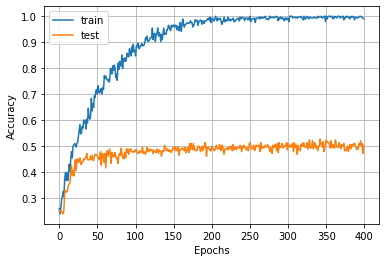

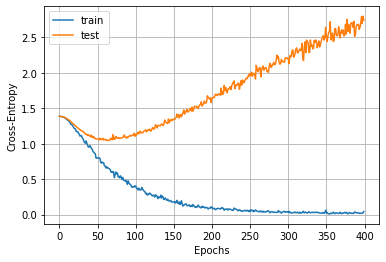

Iteration: 2
9/9 - 0s - loss: 1.8737 - accuracy: 0.5278
kappa:  0.37037037037037035
confusion matrix:
 [[33 21 10  8]
 [25 39  8  0]
 [ 6  6 33 27]
 [ 2  2 21 47]]


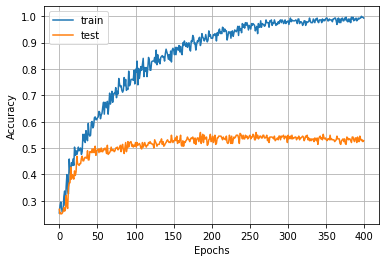

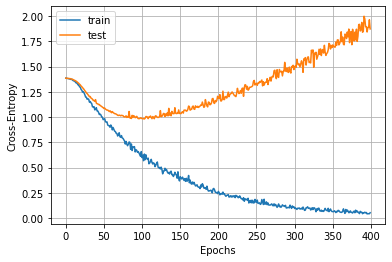


Resultados:
loss: [2.744286298751831, 1.8736653327941895]
accuracy: [0.5034722089767456, 0.5277777910232544]
kappa: [0.3379629629629629, 0.37037037037037035]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 350, 123, 8)       80        
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 175, 61, 8)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 173, 59, 8)        584       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 86, 29, 8)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 84, 27, 8)         584       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 42, 13, 8)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 4368)            

In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.5156
std: (+/- 0.0122)
Mean Kappa: 0.3542
std: (+/- 0.0162)
Max Accuracy: 0.5278
Max Kappa: 0.3704
